In [1]:
import os 
import time
import logging

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint 
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
logging.basicConfig(level=logging.ERROR)

In [3]:
output_dir = 'nmt'
en_vocab_file = os.path.join(output_dir, 'en_vocab')
zh_vocab_file = os.path.join(output_dir, 'zh_vocab')
ckpt_path = os.path.join(output_dir, 'ckpts')
log_dir = os.path.join(output_dir, 'logs')
download_dir = 'tensorflow-dataset/downloads'

In [4]:
tmp_builder = tfds.builder('wmt19_translate/zh-en')
pprint(tmp_builder.subsets)

{Split('train'): ['newscommentary_v14',
                  'wikititles_v1',
                  'uncorpus_v1',
                  'casia2015',
                  'casict2011',
                  'casict2015',
                  'datum2015',
                  'datum2017',
                  'neu2017'],
 Split('validation'): ['newstest2018']}


In [5]:
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3', experiments={tfds.core.Experiment: False}),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

In [6]:
train_examples, val_examples = builder.as_dataset(split=['train[:20%]', 'train[20%:30%]'], as_supervised=True)

In [7]:
for en, zh in train_examples.take(3):
    print(en)
    print(zh)
    print('-' * 10)

tf.Tensor(b'The fear is real and visceral, and politicians ignore it at their peril.', shape=(), dtype=string)
tf.Tensor(b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82', shape=(), dtype=string)
----------
tf.Tensor(b'In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word \xe2\x80\x9cliberal\xe2\x80\x9d \xe2\x80\x93 a champion of the cause of individual freedom.', shape=(), dtype=string)
tf.Tensor(b'\xe4\xba\x8b\xe5\xae\x9e\xe4\xb8\x8a\xef\xbc\x8c\xe5\xbe\xb7\xe5\x9b\xbd\xe6\x94\xbf\xe6\xb2\xbb\xe5\xb1\x80\xe5\x8a\xbf\xe9\x9c\x80\xe8\xa6\x81\xe7\x9a\x84\xe4\xb8\x8d\xe8\xbf\x87\xe6\x98\xaf\xe4\xb8\x80\xe4\xb8\xaa\xe7\xac\xa6\xe5\x90\x88\xe7\xbe\x8e\xe5\x9b\xbd\xe6\x89\x80\xe8\

In [8]:
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
    en = en_t.numpy().decode('utf-8')
    zh = zh_t.numpy().decode('utf-8')
    
    print(en)
    print(zh)
    print('-' * 10)
    
    sample_examples.append((en, zh))

The fear is real and visceral, and politicians ignore it at their peril.
这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
----------
In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word “liberal” – a champion of the cause of individual freedom.
事实上，德国政治局势需要的不过是一个符合美国所谓“自由”定义的真正的自由党派，也就是个人自由事业的倡导者。
----------
Shifting to renewable-energy sources will require enormous effort and major infrastructure investment.
必须付出巨大的努力和基础设施投资才能完成向可再生能源的过渡。
----------
In this sense, it is critical to recognize the fundamental difference between “urban villages” and their rural counterparts.
在这方面，关键在于认识到“城市村落”和农村村落之间的根本区别。
----------
A strong European voice, such as Nicolas Sarkozy’s during the French presidency of the EU, may make a difference, but only for six months, and at the cost of reinforcing other European countries’ nationalist feelings in reaction to the expression of “Gallic pride.”
法国担任轮值主席国期间尼古拉·萨科奇统一的欧洲声音可能让人耳目一新，但这种声音却只持续了短短六个月，而且付出了让其他欧洲国家在面对“高卢人的骄

In [9]:
%%time

try:
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file)
    print('Load exists dict')
except:
    print('There is no dict.  Build from the start.')
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
        (en.numpy() for en, _ in train_examples),
        target_vocab_size=2**13
    )
    
    subword_encoder_en.save_to_file(en_vocab_file)

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_en.subwords[:10]}")
print()

Load exists dict
字典大小：8113
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']

CPU times: user 23.6 ms, sys: 1.57 ms, total: 25.2 ms
Wall time: 26 ms


In [10]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[3461, 7889, 9, 3502, 4379, 1134, 7903]

In [11]:
print('{0:10}{1:6}'.format('Index', 'Subword'))
print('-' * 15)

for idx in indices:
    subword = subword_encoder_en.decode([idx])
    print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 3461     Taiwan
 7889      
    9     is 
 3502     bea
 4379     uti
 1134     ful
 7903     .


In [12]:
%%time
try:
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
    print('load exist dict')
except:
    print('There is no dict.  Build from start.')
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
        (zh.numpy() for _, zh in train_examples),
        target_vocab_size=2**13,
        max_subword_length=1
    )
    
    subword_encoder_zh.save_to_file(zh_vocab_file)
    
print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

load exist dict
字典大小：4205
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 11.9 ms, sys: 3.8 ms, total: 15.7 ms
Wall time: 20.2 ms


In [13]:
def encode(en_t, zh_t):
    en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
    zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
    return en_indices, zh_indices

In [14]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)

print('英文 BOS 的 index', subword_encoder_en.vocab_size)
print('英文 BOS 的 index', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index', subword_encoder_zh.vocab_size)
print('中文 BOS 的 index', subword_encoder_zh.vocab_size + 1)

print('\n輸入為 2 個 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('輸出為 2 個索引序列：')
pprint((en_indices, zh_indices))

英文 BOS 的 index 8113
英文 BOS 的 index 8114
中文 BOS 的 index 4205
中文 BOS 的 index 4206

輸入為 2 個 Tensors：
(<tf.Tensor: shape=(), dtype=string, numpy=b'The fear is real and visceral, and politicians ignore it at their peril.'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82'>)
---------------
輸出為 2 個索引序列：
([8113,
  16,
  1284,
  9,
  243,
  5,
  1275,
  1756,
  156,
  1,
  5,
  1016,
  5566,
  21,
  38,
  33,
  2982,
  7965,
  7903,
  8114],
 [4205,
  10,
  151,
  574,
  1298,
  6,
  374,
  55,
  29,
  193,
  5,
  1,
  3,
  3981,
  931,
  431,
  125,
  1,
  17,
  124,
  33,
  20,
  97,
  1089,
  1247,
  861,
  3,
  4206])


In [15]:
def tf_encode(en_t, zh_t):
    return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])


tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)

tf.Tensor(
[8113   16 1284    9  243    5 1275 1756  156    1    5 1016 5566   21
   38   33 2982 7965 7903 8114], shape=(20,), dtype=int64)
tf.Tensor(
[4205   10  151  574 1298    6  374   55   29  193    5    1    3 3981
  931  431  125    1   17  124   33   20   97 1089 1247  861    3 4206], shape=(28,), dtype=int64)


In [16]:
MAX_LENGTH = 40


def filter_max_length(en, zh, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(en) <= max_length,
                         tf.size(zh) <= max_length)


tmp_dataset = tmp_dataset.filter(filter_max_length)

In [17]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113   16 1284 ...    0    0    0]
 [8113 1894 1302 ...    0    0    0]
 [8113   44   40 ...    0    0    0]
 ...
 [8113  122  506 ...    0    0    0]
 [8113   16  215 ...    0    0    0]
 [8113 7443 7889 ...    0    0    0]], shape=(64, 39), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   10  151 ...    0    0    0]
 [4205  206  275 ...    0    0    0]
 [4205    5   10 ...    0    0    0]
 ...
 [4205   34    6 ...    0    0    0]
 [4205  317  256 ...    0    0    0]
 [4205  167  326 ...    0    0    0]], shape=(64, 40), dtype=int64)


In [18]:
MAX_LENGTH = 40
BATCH_SIZE = 128
BUFFER_SIZE = 15000

# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 驗證集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

In [19]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113 7064 1975 ...    0    0    0]
 [8113 4154 5813 ...    0    0    0]
 [8113 5261 5814 ...    0    0    0]
 ...
 [8113   44   40 ...    0    0    0]
 [8113   16 5037 ...    0    0    0]
 [8113 1392    1 ...    0    0    0]], shape=(128, 39), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205  677  198 ...    0    0    0]
 [4205  327  363 ...    0    0    0]
 [4205  146  450 ... 4206    0    0]
 ...
 [4205  146   10 ...    0    0    0]
 [4205   73   76 ...    0    0    0]
 [4205   72  107 ...    0    0    0]], shape=(128, 40), dtype=int64)


In [20]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


In [21]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 並添加 padding token: <pad> 來確保 batch 裡的句子有一樣長度
demo_dataset = demo_examples.map(tf_encode)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出這個 demo dataset 裡唯一一個 batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)


In [22]:
def create_padding_mask(seq):
    mask = tf.cast(tf.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]


inp_mask = create_padding_mask(inp)

In [25]:
print('inp:', inp)
print('-'*50)
print('inp_mask', tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------------------------------------
inp_mask tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


In [27]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

(<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
 array([[[-0.02297657, -0.04122313,  0.03381893, -0.01937288],
         [-0.00796111,  0.03261266, -0.00197904, -0.00650675],
         [ 0.03392147,  0.01473037, -0.01506079, -0.00136057],
         [-0.00279899,  0.00668357, -0.01596413, -0.03195436],
         [ 0.04876539, -0.01745915, -0.00553452,  0.03104443],
         [ 0.02287232,  0.00264494, -0.00776212,  0.00823762],
         [ 0.02976597,  0.00305575, -0.02176636, -0.04857057],
         [ 0.02976597,  0.00305575, -0.02176636, -0.04857057]],
 
        [[-0.02297657, -0.04122313,  0.03381893, -0.01937288],
         [ 0.04378113, -0.02505095, -0.00220025,  0.01047223],
         [ 0.02366493,  0.0475367 , -0.03152323, -0.02946496],
         [ 0.03044384,  0.02730397, -0.02224587, -0.02248793],
         [ 0.04138756, -0.02679635,  0.02611503, -0.04867743],
         [-0.04007994,  0.04466505, -0.01300593,  0.01717355],
         [ 0.04876539, -0.01745915, -0.00553452,  0.03104443],


In [30]:
tf.random.set_seed(9527)
q = emb_inp
k = emb_inp

v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)

In [32]:
v

<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

In [51]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """Calculate the attention weights.
    
    q, k, v msut hvae matching leading dimensions.
    k, v must have matching penulatimate dimension, i.e: seq_len_k = seq_len_v.
    The mask has different shape depending on its type(padding or look ahead)
    but it must be broadcastable for addition.
    
    Args:
        q: qeury shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable
                to (..., seq_len_q, seq_len_k). Defaults to None
    
    Returns:
        output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [52]:
output, attention_weights = scaled_dot_product_attention(q, k, v)

In [53]:
print('output:', output)
print('-' * 50)
print('attention', attention_weights)

output: tf.Tensor(
[[[0.37521768 0.37489307 0.37494543 0.49979818]
  [0.3748902  0.37507972 0.37497297 0.5000956 ]
  [0.37486172 0.37503427 0.37506902 0.50009096]
  [0.3749019  0.37503254 0.3750249  0.5000169 ]
  [0.3750128  0.37494376 0.37508774 0.50001013]
  [0.37494963 0.3750031  0.37504426 0.50004125]
  [0.37482387 0.37502173 0.3750947  0.50002766]
  [0.37482387 0.37502173 0.3750947  0.50002766]]

 [[0.6249323  0.2500742  0.6250535  0.37533674]
  [0.6247665  0.24986461 0.62485605 0.37480456]
  [0.6251128  0.24998832 0.6248617  0.3747517 ]
  [0.62501323 0.24995726 0.624849   0.37477267]
  [0.6247715  0.24996923 0.6247686  0.37503192]
  [0.6252786  0.25009668 0.6251763  0.3750379 ]
  [0.62476134 0.24983317 0.6248728  0.374716  ]
  [0.62493014 0.24993305 0.62492955 0.37484244]]], shape=(2, 8, 4), dtype=float32)
--------------------------------------------------
attention tf.Tensor(
[[[0.12525634 0.12495305 0.12490512 0.1250137  0.12494761 0.1249559
   0.12498412 0.12498412]
  [0.12493

In [54]:
mask = tf.squeeze(inp_mask, axis=1)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print(attention_weights)

tf.Tensor(
[[[0.16700138 0.16659701 0.1665331  0.16667785 0.16658977 0.16660081
   0.         0.        ]
  [0.16658151 0.16677116 0.1666941  0.16671334 0.16657767 0.16666219
   0.         0.        ]
  [0.16647454 0.16665098 0.16676328 0.16665417 0.16675009 0.16670693
   0.         0.        ]
  [0.16664703 0.16669802 0.16668199 0.16676877 0.16656166 0.16664258
   0.         0.        ]
  [0.16652603 0.16652942 0.16674495 0.16652875 0.16693173 0.16673909
   0.         0.        ]
  [0.16655684 0.16663368 0.16672157 0.16662939 0.16675887 0.16669971
   0.         0.        ]
  [0.16656946 0.16663833 0.16674058 0.16677293 0.16662075 0.16665798
   0.         0.        ]
  [0.16656946 0.16663833 0.16674058 0.16677293 0.16662075 0.16665798
   0.         0.        ]]

 [[0.1252625  0.12501243 0.12484077 0.12489426 0.12515192 0.1249223
   0.12495375 0.12496204]
  [0.12493996 0.12512185 0.12493101 0.1249845  0.12507538 0.12478922
   0.12513754 0.12502052]
  [0.12476337 0.12492595 0.1252434  0.

In [59]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask


seq_len = emb_tar.shape[1]
look_ahead_mask = create_look_ahead_mask(seq_len)
print('emb_tar:', emb_tar)
print('-' * 50)
print('look_ahead_mask', look_ahead_mask)

emb_tar: tf.Tensor(
[[[ 3.5666537e-02  5.5825487e-03  5.4331906e-03  4.0096808e-02]
  [ 7.2124116e-03 -4.1118335e-02 -2.7754916e-02 -4.1599952e-02]
  [-1.7930616e-02 -1.8189169e-02 -1.3243929e-03 -4.7433127e-02]
  [-1.3495907e-03  1.7305706e-02 -1.5348159e-02 -4.1189052e-02]
  [-1.5888382e-02 -4.5061111e-05 -4.7153607e-03  2.2980023e-02]
  [ 4.8545565e-02 -4.0312864e-02  4.5347214e-04  4.1490231e-02]
  [-4.0585827e-02  2.0542037e-02  2.9793326e-02 -1.9847764e-02]
  [ 4.1308645e-02 -4.2330813e-02  3.7144307e-02  6.7838058e-03]
  [ 4.1308645e-02 -4.2330813e-02  3.7144307e-02  6.7838058e-03]
  [ 4.1308645e-02 -4.2330813e-02  3.7144307e-02  6.7838058e-03]]

 [[ 3.5666537e-02  5.5825487e-03  5.4331906e-03  4.0096808e-02]
  [-3.7920427e-02  3.2582048e-02  3.9499886e-03 -2.5687337e-02]
  [-3.1952970e-03 -4.6193227e-03 -3.7512720e-02  2.8303992e-02]
  [ 3.6210943e-02 -6.2573664e-03  1.4258470e-02 -3.1804100e-02]
  [ 1.4585648e-02 -1.7319262e-02  3.2460537e-02  2.3770537e-02]
  [ 2.6244011e-02 

In [63]:
tmp_q, tmp_k = emb_tar
tmp_v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

_, attention_weights = scaled_dot_product_attention(tmp_q, tmp_k ,tmp_v, look_ahead_mask)

print('attention_weights:', attention_weights)

attention_weights: tf.Tensor(
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.49985787 0.5001421  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.3330306  0.33368912 0.33328027 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.24978316 0.2501955  0.24991067 0.25011066 0.         0.
  0.         0.         0.         0.        ]
 [0.20003313 0.19999945 0.20008808 0.19986297 0.20001645 0.
  0.         0.         0.         0.        ]
 [0.16684994 0.16623451 0.16668451 0.16664355 0.16678612 0.16680142
  0.         0.         0.         0.        ]
 [0.14275907 0.1431023  0.14278208 0.1428608  0.14286722 0.14274146
  0.14288701 0.         0.         0.        ]
 [0.12510368 0.12481104 0.12492563 0.12512645 0.12516575 0.1250838
  0.12479433 0.12498935 0.         0.        ]
 [0.11117881 0.11091873 0.11102057 0.11119903 0.11123395 0.11116114
  0.11090388 0.1110772 

In [69]:
def split_heads(x, d_model, num_heads):
    # x.shape: (batch_size, seq_len, d_model)
    batch_size = tf.shape(x)[0]
  
    # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
    assert d_model % num_heads == 0
    depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
    # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
    # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
    # (batch_size, seq_len, num_heads, depth)
    reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
    # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
    # (batch_size, num_heads, seq_len, depth)
    output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
    return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print("output:", output)

x: tf.Tensor(
[[[-0.02297657 -0.04122313  0.03381893 -0.01937288]
  [-0.00796111  0.03261266 -0.00197904 -0.00650675]
  [ 0.03392147  0.01473037 -0.01506079 -0.00136057]
  [-0.00279899  0.00668357 -0.01596413 -0.03195436]
  [ 0.04876539 -0.01745915 -0.00553452  0.03104443]
  [ 0.02287232  0.00264494 -0.00776212  0.00823762]
  [ 0.02976597  0.00305575 -0.02176636 -0.04857057]
  [ 0.02976597  0.00305575 -0.02176636 -0.04857057]]

 [[-0.02297657 -0.04122313  0.03381893 -0.01937288]
  [ 0.04378113 -0.02505095 -0.00220025  0.01047223]
  [ 0.02366493  0.0475367  -0.03152323 -0.02946496]
  [ 0.03044384  0.02730397 -0.02224587 -0.02248793]
  [ 0.04138756 -0.02679635  0.02611503 -0.04867743]
  [-0.04007994  0.04466505 -0.01300593  0.01717355]
  [ 0.04876539 -0.01745915 -0.00553452  0.03104443]
  [ 0.02287232  0.00264494 -0.00776212  0.00823762]]], shape=(2, 8, 4), dtype=float32)
output: tf.Tensor(
[[[[-0.02297657 -0.04122313]
   [-0.00796111  0.03261266]
   [ 0.03392147  0.01473037]
   [-0.0027

In [78]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights

In [79]:
assert d_model == emb_inp.shape[-1] == 4
num_heads = 2

print('d_model:', d_model)
print('num_heads:', num_heads)

mha = MultiHeadAttention(d_model, num_heads)

v = k = v = emb_inp
padding_mask = create_padding_mask(inp)
print('q.shape:', q.shape)
print('k.shape:', k.shape)
print('v.shape:', v.shape)
print('padding_mask.shape:', padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print('output.shape:', output.shape)
print('attention_weights.shape:', attention_weights.shape)
print('\noutput:', output)

d_model: 4
num_heads: 2
q.shape: (2, 8, 4)
k.shape: (2, 8, 4)
v.shape: (2, 8, 4)
padding_mask.shape: (2, 1, 1, 8)
output.shape: (2, 8, 4)
attention_weights.shape: (2, 2, 8, 8)

output: tf.Tensor(
[[[ 0.01288779 -0.00919982 -0.00923284 -0.00198364]
  [ 0.01287623 -0.00920211 -0.00924341 -0.00196247]
  [ 0.01287655 -0.00920623 -0.00925122 -0.00195355]
  [ 0.01287263 -0.00919964 -0.0092411  -0.0019619 ]
  [ 0.01288756 -0.00921092 -0.00925501 -0.00195726]
  [ 0.01288115 -0.00920624 -0.00924921 -0.00195916]
  [ 0.01286814 -0.00920093 -0.00924509 -0.00195434]
  [ 0.01286814 -0.00920093 -0.00924509 -0.00195434]]

 [[ 0.01634819 -0.00924758 -0.01036824 -0.00086632]
  [ 0.01634617 -0.00925161 -0.01041402 -0.00078698]
  [ 0.0163274  -0.00924201 -0.01042373 -0.00074827]
  [ 0.01633203 -0.00924439 -0.01042066 -0.00075906]
  [ 0.01634008 -0.00924724 -0.0103969  -0.00081006]
  [ 0.01634056 -0.00924514 -0.01039747 -0.00080687]
  [ 0.01634921 -0.00925385 -0.01042158 -0.00077777]
  [ 0.01634275 -0.0092

In [80]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [90]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, attn = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [91]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)
--------------------
emb_inp: tf.Tensor(
[[[-0.02297657 -0.04122313  0.03381893 -0.01937288]
  [-0.00796111  0.03261266 -0.00197904 -0.00650675]
  [ 0.03392147  0.01473037 -0.01506079 -0.00136057]
  [-0.00279899  0.00668357 -0.01596413 -0.03195436]
  [ 0.04876539 -0.01745915 -0.00553452  0.03104443]
  [ 0.02287232  0.00264494 -0.00776212  0.00823762]
  [ 0.02976597  0.00305575 -0.02176636 -0.04857057]
  [ 0.02976597  0.00305575 -0.02176636 -0.04857057]]

 [[-0.02297657 -0.04122313  0.03381893 -0.01937288]
  [ 0.04378113 -0.02505095 -0.00220025  0.01047223]
  [ 0.02366493  0.0475367  -0.03152323 -0.02946496]
  [ 0.03044384  0.02730397 -0.02224587 -0.02248793]
  [ 0.04138756 -0.02679635  0.02611503 -0.04867743]
  [

In [98]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
        attn1, attn_weights_bolck1 = self.mha1(x, x, x, combined_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, inp_padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_bolck1, attn_weights_block2

In [99]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combine_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print('tar:', tar)
print('tar_padding_mask:', tar_padding_mask)
print('look_ahead_mask:', look_ahead_mask)
print('combined_mask:', combine_mask)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
tar_padding_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 10), dtype=float32)
look_ahead_mask: tf.Tensor(
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0

In [100]:
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask
)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

emb_tar: tf.Tensor(
[[[ 3.5666537e-02  5.5825487e-03  5.4331906e-03  4.0096808e-02]
  [ 7.2124116e-03 -4.1118335e-02 -2.7754916e-02 -4.1599952e-02]
  [-1.7930616e-02 -1.8189169e-02 -1.3243929e-03 -4.7433127e-02]
  [-1.3495907e-03  1.7305706e-02 -1.5348159e-02 -4.1189052e-02]
  [-1.5888382e-02 -4.5061111e-05 -4.7153607e-03  2.2980023e-02]
  [ 4.8545565e-02 -4.0312864e-02  4.5347214e-04  4.1490231e-02]
  [-4.0585827e-02  2.0542037e-02  2.9793326e-02 -1.9847764e-02]
  [ 4.1308645e-02 -4.2330813e-02  3.7144307e-02  6.7838058e-03]
  [ 4.1308645e-02 -4.2330813e-02  3.7144307e-02  6.7838058e-03]
  [ 4.1308645e-02 -4.2330813e-02  3.7144307e-02  6.7838058e-03]]

 [[ 3.5666537e-02  5.5825487e-03  5.4331906e-03  4.0096808e-02]
  [-3.7920427e-02  3.2582048e-02  3.9499886e-03 -2.5687337e-02]
  [-3.1952970e-03 -4.6193227e-03 -3.7512720e-02  2.8303992e-02]
  [ 3.6210943e-02 -6.2573664e-03  1.4258470e-02 -3.1804100e-02]
  [ 1.4585648e-02 -1.7319262e-02  3.2460537e-02  2.3770537e-02]
  [ 2.6244011e-02 

In [102]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)
    
    sines = np.sin(angle_rads[:, 0::2])
    
    cosines = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = np.concatenate([sines, cosines], axis=1)
    
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

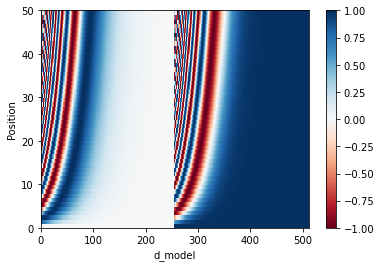

In [104]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [107]:
class Encoder(tf.keras.layers.Layer):
    # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
    # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
    # - input_vocab_size: 用來把索引轉成詞嵌入向量
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
    
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
        # 建立 `num_layers` 個 EncoderLayers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # 輸入的 x.shape == (batch_size, input_seq_len)
        # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
        input_seq_len = tf.shape(x)[1]
    
        # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
        # 再加上對應長度的位置編碼
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :input_seq_len, :]

        # 對 embedding 跟位置編碼的總合做 regularization
        # 這在 Decoder 也會做
        x = self.dropout(x, training=training)
    
        # 通過 N 個 EncoderLayer 做編碼
        for i, enc_layer in enumerate(self.enc_layers):
            x = enc_layer(x, training, mask)
            # 以下只是用來 demo EncoderLayer outputs
            #print('-' * 20)
            #print(f"EncoderLayer {i + 1}'s output:", x)
      
        return x 

In [108]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
enc_out: tf.Tensor(
[[[-1.0038205  -0.45496085 -0.19832987  1.6571113 ]
  [-0.55373764 -0.61151147 -0.5664016   1.7316508 ]
  [-0.5271825  -0.3902845  -0.79603344  1.7135004 ]
  [-0.7932742  -0.18683454 -0.7048304   1.6849391 ]
  [-1.0119269  -0.08384517 -0.5403726   1.6361448 ]
  [-1.1781926  -0.10394833 -0.3020925   1.5842334 ]
  [-1.069806   -0.34945896 -0.2194089   1.6386738 ]
  [-0.66219264 -0.60785806 -0.45710376  1.7271545 ]]

 [[-1.013355   -0.43549132 -0.2066725   1.6555188 ]
  [-0.6518722  -0.5328544  -0.5454718   1.7301984 ]
  [-0.5431334  -0.39416707 -0.7784202   1.7157208 ]
  [-0.75860286 -0.19505598 -0.7339016   1.6875606 ]
  [-1.0094789  -0.09481923 -0.53464025  1.6389384 ]
  [-1.1836779  -0.11553008 -0.2835592   1.5827671 ]
  [-1.1175152  -0.27072194 -0.23169592  1.6199334 ]
  [-0.7388084  -0.55241764 -0.4303427   1.7215

In [116]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
        
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, combined_mask, inp_padding_mask):
        tar_seq_len = tf.shape(x)[1]
        
        attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
        
        x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :tar_seq_len, :]
        x = self.dropout(x, training=training)
        
        for i, dec_layer in enumerate(self.dec_layers):
            x, block1, block2 = dec_layer(x, enc_output, training, combined_mask, inp_padding_mask)
                
            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
            
        # x.shape == (batch_size, tar_seq_len, d_model)
        return x, attention_weights

In [117]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
    print(f"{block_name}.shape: {attn_weights.shape}")

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
combined_mask: tf.Tensor(
[[[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 10, 10), dtype=float32)
--------------------
enc_out: tf.Tensor(
[[[-1.0038205  

In [119]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_szie, target_vocab_szie, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, rate)
        
        # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
    # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
    def call(self, inp, tar, training, enc_padding_mask, combined_mask, dec_padding_mask):
        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, combined_mask, dec_padding_mask)
        
        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights

In [127]:
# 超參數
num_layers = 6
d_model = 4
num_heads = 2
dff = 8

# + 2 是為了 <start> & <end> token
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2

# 重點中的重點。訓練時用前一個字來預測下一個中文字
tar_inp = tar[:, :-1]
tar_real = tar[:, 1:]

# 來源 / 目標語言用的遮罩。注意 `combined_mask` 已經將目標語言的兩種遮罩合而為一
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar_inp)
look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化我們的第一個 transformer
transformer = Transformer(num_layers, d_model, num_heads, dff, 
                          input_vocab_size, output_vocab_size)

# 將英文、中文序列丟入取得 Transformer 預測下個中文字的結果
predictions, attn_weights = transformer(inp, tar_inp, False, inp_padding_mask, 
                                        combined_mask, inp_padding_mask)

print("tar:", tar)
print("-" * 20)
print("tar_inp:", tar_inp)
print("-" * 20)
print("tar_real:", tar_real)
print("-" * 20)
print("predictions:", predictions)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)
--------------------
tar_inp: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0]
 [4205  165  489  398  191   14    7  560    3]], shape=(2, 9), dtype=int64)
--------------------
tar_real: tf.Tensor(
[[  10  241   86   27    3 4206    0    0    0]
 [ 165  489  398  191   14    7  560    3 4206]], shape=(2, 9), dtype=int64)
--------------------
predictions: tf.Tensor(
[[[ 0.09636697 -0.06143762  0.04594332 ...  0.00860998  0.00873263
   -0.0554506 ]
  [ 0.09114663 -0.06999018  0.05286894 ...  0.00027743 -0.00401425
   -0.05197208]
  [ 0.09321959 -0.06701639  0.05042911 ...  0.00369672  0.00133362
   -0.05361196]
  ...
  [ 0.09338701 -0.06670718  0.05015506 ...  0.00437496  0.00249683
   -0.05399878]
  [ 0.08867302 -0.07300584  0.05531472 ... -0.0027572  -0.00856237
   -0.05052562]
  [ 0.09297653 -0.06736148  0.05068985 ...  0.003

In [128]:
transformer.summary()

Model: "transformer_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_4 (Encoder)          multiple                  33492     
_________________________________________________________________
decoder_7 (Decoder)          multiple                  18388     
_________________________________________________________________
dense_410 (Dense)            multiple                  21035     
Total params: 72,915
Trainable params: 72,915
Non-trainable params: 0
_________________________________________________________________


In [129]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    # 照樣計算所有位置的 cross entropy 但不加總
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    # 只計算非 <pad> 位置的損失 
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [131]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [132]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = subword_encoder_en.vocab_size + 2
target_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

print("input_vocab_size:", input_vocab_size)
print("target_vocab_size:", target_vocab_size)

input_vocab_size: 8115
target_vocab_size: 4207


In [134]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    

# 將客製化 learning rate schdeule 丟入 Adam opt.
# Adam opt. 的參數都跟論文相同
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

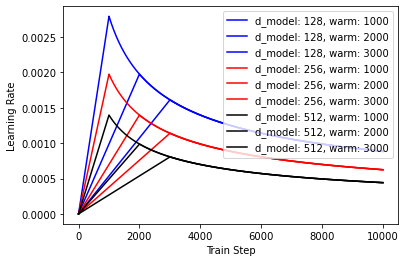

In [135]:
d_models = [128, 256, 512]
warmup_steps = [1000 * i for i in range(1, 4)]

schedules = []
labels = []
colors = ["blue", "red", "black"]
for d in d_models:
    schedules += [CustomSchedule(d, s) for s in warmup_steps]
    labels += [f"d_model: {d}, warm: {s}" for s in warmup_steps]

for i, (schedule, label) in enumerate(zip(schedules, labels)):
    plt.plot(schedule(tf.range(10000, dtype=tf.float32)), 
           label=label, color=colors[i // 3])

plt.legend()

plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [136]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

print(f"""這個 Transformer 有 {num_layers} 層 Encoder / Decoder layers
d_model: {d_model}
num_heads: {num_heads}
dff: {dff}
input_vocab_size: {input_vocab_size}
target_vocab_size: {target_vocab_size}
dropout_rate: {dropout_rate}

""")

這個 Transformer 有 4 層 Encoder / Decoder layers
d_model: 128
num_heads: 8
dff: 512
input_vocab_size: 8115
target_vocab_size: 4207
dropout_rate: 0.1




In [143]:
train_perc = 20
val_prec = 1
drop_prec = 100 - train_perc - val_prec

checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff_{train_perc}train_perc"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

# tf.train.Checkpoint 可以幫我們把想要存下來的東西整合起來，方便儲存與讀取
# 一般來說你會想存下模型以及 optimizer 的狀態
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

# ckpt_manager 會去 checkpoint_path 看有沒有符合 ckpt 裡頭定義的東西
# 存檔的時候只保留最近 5 次 checkpoints，其他自動刪除
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果在 checkpoint 路徑上有發現檔案就讀進來
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
  
    # 用來確認之前訓練多少 epochs 了
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
    last_epoch = 0
    print("沒找到 checkpoint，從頭訓練。")

沒找到 checkpoint，從頭訓練。


In [138]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

In [145]:
@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
    # 前面說過的，用去尾的原始序列去預測下一個字的序列
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # 建立 3 個遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
    with tf.GradientTape() as tape:
        # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
        loss = loss_function(tar_real, predictions)

    # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
# 定義我們要看幾遍數據集
EPOCHS = 30
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS)}")


summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(last_epoch, EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (step_idx, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
            
    with summary_writer.as_default():
        tf.summart.scalar('train_loss', train_loss.result(), step=epoch + 1)
        tf.summart.scalar('train_acc', train_accuracy.result(), step=epoch + 1)
        
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 0 epochs。
剩餘 epochs：-30


In [141]:
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
    # 準備英文句子前後會加上的 <start>, <end>
    start_token = [subword_encoder_en.vocab_size]
    end_token = [subword_encoder_en.vocab_size + 1]

    # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列
    # 並在前後加上 BOS / EOS
    inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 跟我們在影片裡看到的一樣，Decoder 在第一個時間點吃進去的輸入
    # 是一個只包含一個中文 <start> token 的序列
    decoder_input = [subword_encoder_zh.vocab_size]
    output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度

    # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
    for i in range(MAX_LENGTH):
        # 每多一個生成的字就得產生新的遮罩
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
        if tf.equal(predicted_id, subword_encoder_zh.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        # 將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
        # 下個中文字的時候關注到最新的 `predicted_id`
        output = tf.concat([output, predicted_id], axis=-1)

    # 將 batch 的維度去掉後回傳預測的中文索引序列
    return tf.squeeze(output, axis=0), attention_weights
